## Quick MNIST example

#### Imports

In [21]:
import os
import sys
import torch
import torchsummary
import wget
import tensorboard
import torchvision
import matplotlib.pyplot as plt
import pandas as pd

sys.path.insert(0, os.path.abspath("../.."))

import numpy as np
import vegans.utils.loading as loading
import vegans.utils as utils
from vegans.GAN import ConditionalVanillaGAN

In [15]:
from clearml import Task
task = Task.init('vegans', 'mnist-toy')
task.execute_remotely('gpu_support')

ClearML Task: created new task id=7f9b99d8baf345d0b3d00f1832898784
ClearML results page: http://clearml.mlops.unit8/projects/a66576707b9b4067aaa75a2c9c77afda/experiments/7f9b99d8baf345d0b3d00f1832898784/output/log
2021-05-11 11:51:44,830 - clearml.Task - INFO - Waiting for repository detection and full package requirement analysis
2021-05-11 11:51:44,870 - clearml.Task - INFO - Finished repository detection and package analysis
2021-05-11 11:51:49,350 - clearml - WARNING - Switching to remote execution, output log page http://clearml.mlops.unit8/projects/a66576707b9b4067aaa75a2c9c77afda/experiments/7f9b99d8baf345d0b3d00f1832898784/output/log
2021-05-11 11:51:49,351 - clearml - WARNING - Terminating local execution process


NameError: name 'exit' is not defined

In [3]:
#! pip install ipywidgets
#! jupyter nbextension enable --py widgetsnbextension

#### Load Data

In [4]:
loader = loading.MNISTLoader()
X_train, y_train, X_test, y_test = loader.load()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 1, 32, 32) (60000, 10) (10000, 1, 32, 32) (10000, 10)


#### Preprocessing

In [16]:
x_dim = X_train.shape[1:]
y_dim = y_train.shape[1:]
z_dim = 64

epochs = 1

#### Define architecture

In [17]:
generator = loader.load_generator(z_dim=z_dim)
discriminator = loader.load_adversary()

gan_model = ConditionalVanillaGAN(
    generator=generator, adversary=discriminator,
    x_dim=x_dim, z_dim=z_dim, y_dim=y_dim,
    optim=None, optim_kwargs=None,                # Optional
    feature_layer=None,                           # Optional
    fixed_noise_size=32,                          # Optional
    device=None,                                  # Optional
    ngpu=None,                                    # Optional
    folder=".veganModels/cVanillaGAN",            # Optional
    secure=True                                   # Optional
)
gan_model.summary()

Generator
---------
Input shape:  (74,)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          19,200
      LayerReshape-2            [-1, 1, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]           1,664
       BatchNorm2d-4             [-1, 64, 8, 8]             128
         LeakyReLU-5             [-1, 64, 8, 8]               0
            Conv2d-6            [-1, 128, 4, 4]         204,928
       BatchNorm2d-7            [-1, 128, 4, 4]             256
         LeakyReLU-8            [-1, 128, 4, 4]               0
            Conv2d-9            [-1, 256, 4, 4]         295,168
      BatchNorm2d-10            [-1, 256, 4, 4]             512
        LeakyReLU-11            [-1, 256, 4, 4]               0
  ConvTranspose2d-12            [-1, 128, 8, 8]         524,416
      BatchNorm2d-13            [-1, 128, 8, 8]             256

#### Train model

In [18]:
gan_model.fit(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,           # Optional
    y_test=y_test,           # Optional
    batch_size=32,           # Optional
    epochs=epochs,                # Optional
    steps=None,              # Optional
    print_every="0.2e",      # Optional
    save_model_every=None,   # Optional
    save_images_every=None,  # Optional
    save_losses_every=10,    # Optional
    enable_tensorboard=False # Optional
)

------------------------------------------------------------
EPOCH: 1
------------------------------------------------------------


KeyboardInterrupt: 

#### Evaluation

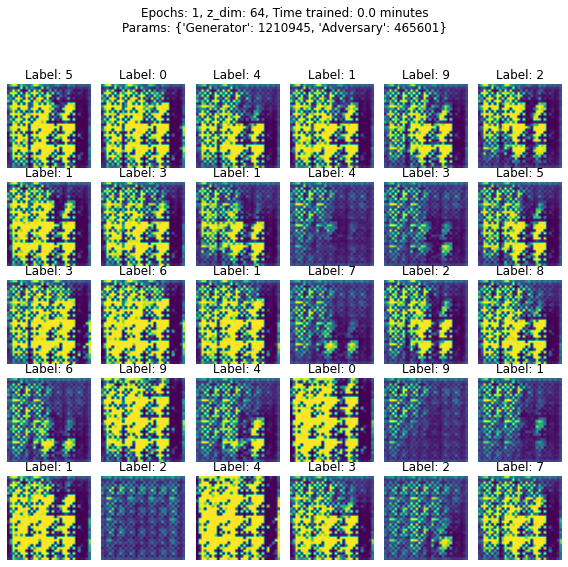

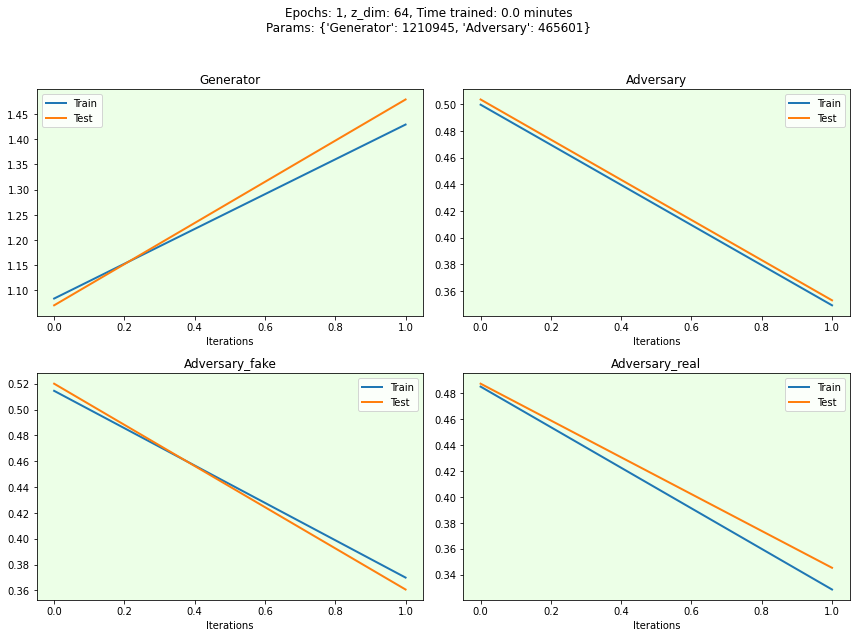

In [23]:
samples, losses = gan_model.get_training_results(by_epoch=False)

training_time = np.round(gan_model.total_training_time/60, 2)
title = "Epochs: {}, z_dim: {}, Time trained: {} minutes\nParams: {}\n\n".format(
    epochs, z_dim, training_time, gan_model.get_number_params()
)
fixed_labels = np.argmax(gan_model.get_fixed_labels(), axis=1)
fig, axs = utils.plot_images(images=samples, labels=fixed_labels, show=False)
fig.suptitle(title, fontsize=12)
fig.tight_layout()
plt.savefig(gan_model.folder+"/generated_images.png")

fig, axs = utils.plot_losses(losses=losses, show=False)
fig.suptitle(title, fontsize=12)
fig.tight_layout()
plt.savefig(gan_model.folder+"/losses.png")

In [ ]:
task.upload_artifact('LoggedFolder', artifact_object=os.path.join(gan_model.folder))